In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
# plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import matplotlib as mpl
# data 
import numpy as np
# file IO
import csv
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED

# Read Data

In [2]:
def PrintNumber(myDict) :
    for key,val in myDict.items():
        if(isinstance(val,np.ndarray)):
            print(key,'\t',len(val)) 
        elif(isinstance(val,dict)):
            print(key,end='')
            for key1,val1 in val.items():
                print('\t',key1,'\t',len(val1))

In [3]:
# read AGN IDs
agnIDs = adp.ReadFile(adp.path_csv+'\\v2_AGNid_tricolor.csv')

# convert agnIDs into dict of integer numpy arrays 
agnIDs_dict = {
    'RED' : np.array(agnIDs[0], dtype=int),
    'GRN' : np.array(agnIDs[1], dtype=int),
    'BLU' : np.array(agnIDs[2], dtype=int)
}

# verify nmber of sources
PrintNumber(agnIDs_dict)

Cropped:  ['Row 1 = MIR exclusive AGN with id, redshift, IRAC, and 24um (n=352). Row 2 = MIR-X-ray inclusive AGN with id, redshift, IRAC, and 24um (n=548). Row 3 = X-ray exclusive AGN with id, redshift, IRAC, and 24um (n=1227). ']
RED 	 352
GRN 	 548
BLU 	 1227


In [4]:
# get redshifts
zDict = adp.ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')

Cropped:  ['ID', 'z']
Number of redshifts: 485793


In [5]:
agnInfo = {}
for key,val in agnIDs_dict.items():
    # match redshift to AGN
    key_zid, key_idz = match.match(zDict['ID'], val)
    agnInfo[key] = {
        'ID' : val[key_idz],
        'z'  : zDict['z'][key_zid]
    }
# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 352
	 z 	 352
GRN	 ID 	 548
	 z 	 548
BLU	 ID 	 1227
	 z 	 1227


In [6]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data

# Prepare SEDs

In [7]:
# get starting info 
Fnu_uJy = SED.GetPhotometry(data20, print=False)
IDs_all = SED.GetID(data20, print=False)
lam_A   = SED.GetObservedWavelengths_A(print=False)

In [8]:
for key,val in agnInfo.items():
    # match photometry to AGN
    key_agn, key_phot = match.match(val['ID'], IDs_all)
    # get phot
    Fnu = Fnu_uJy[key_phot]
    # get rest wavelength 
    lamR = SED.ConvertToRestWavelength(val['z'], print=False)
    # get energy density and normalize
    lamFlam = SED.ConvertToEnergyDensity(lamR, Fnu, print=False)
    lamFlam_norm = SED.NormalizeSED_1um(lamR, lamFlam, print=False)
    # get luminosity at 1um
    lum1um = SED.Lum_at1um(lamFlam, lamR, val['z'], )
    # append info
    val['Rest Wavelength'] = lamR
    val['Energy Density'] = lamFlam
    val['Energy Density Normalized at 1um'] = lamFlam_norm
    val['Luminosity at 1um'] = lum1um

# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 352
	 z 	 352
	 Rest Wavelength 	 352
	 Energy Density 	 352
	 Energy Density Normalized at 1um 	 352
	 Luminosity at 1um 	 352
GRN	 ID 	 548
	 z 	 548
	 Rest Wavelength 	 548
	 Energy Density 	 548
	 Energy Density Normalized at 1um 	 548
	 Luminosity at 1um 	 548
BLU	 ID 	 1227
	 z 	 1227
	 Rest Wavelength 	 1227
	 Energy Density 	 1227
	 Energy Density Normalized at 1um 	 1227
	 Luminosity at 1um 	 1227


In [9]:
# get z subsample

# initialize 
agnInfo_zle = {}
# itereate through each agn type 
for key_color, val_dict in agnInfo.items():
    # get boolean mask of redshifts <=1 
    zmask = (val_dict['z'] <= 1)
    # apply mask to each dict
    info = {}
    for key,val in val_dict.items():
        info[key] = val[zmask]
    # add info dict to larger dict 
    agnInfo_zle[key_color] = info 

# verify number of sources
PrintNumber(agnInfo_zle)

RED	 ID 	 79
	 z 	 79
	 Rest Wavelength 	 79
	 Energy Density 	 79
	 Energy Density Normalized at 1um 	 79
	 Luminosity at 1um 	 79
GRN	 ID 	 80
	 z 	 80
	 Rest Wavelength 	 80
	 Energy Density 	 80
	 Energy Density Normalized at 1um 	 80
	 Luminosity at 1um 	 80
BLU	 ID 	 301
	 z 	 301
	 Rest Wavelength 	 301
	 Energy Density 	 301
	 Energy Density Normalized at 1um 	 301
	 Luminosity at 1um 	 301


# Plot SEDs

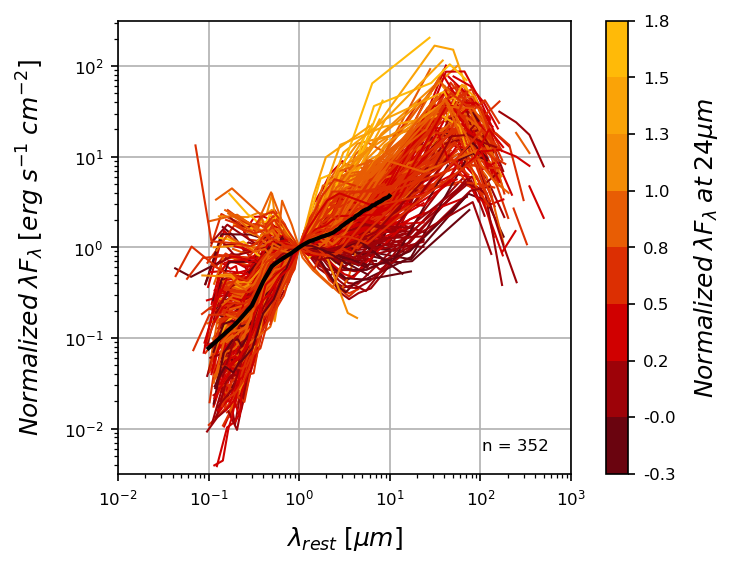

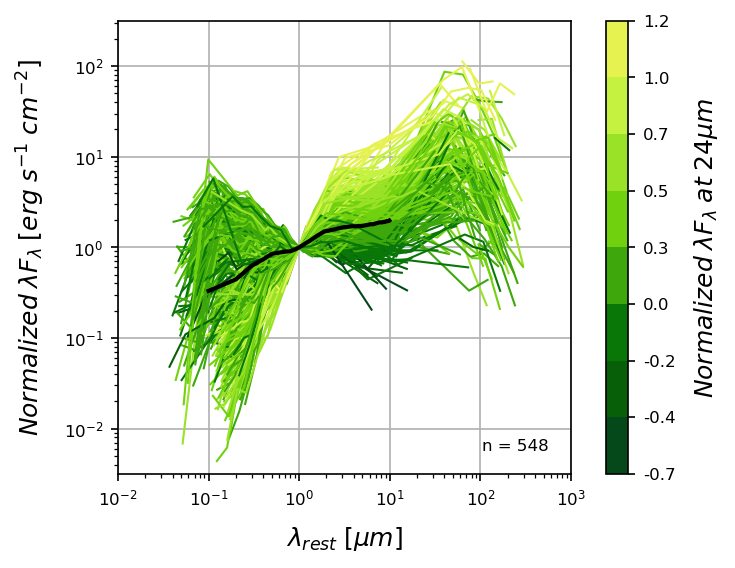

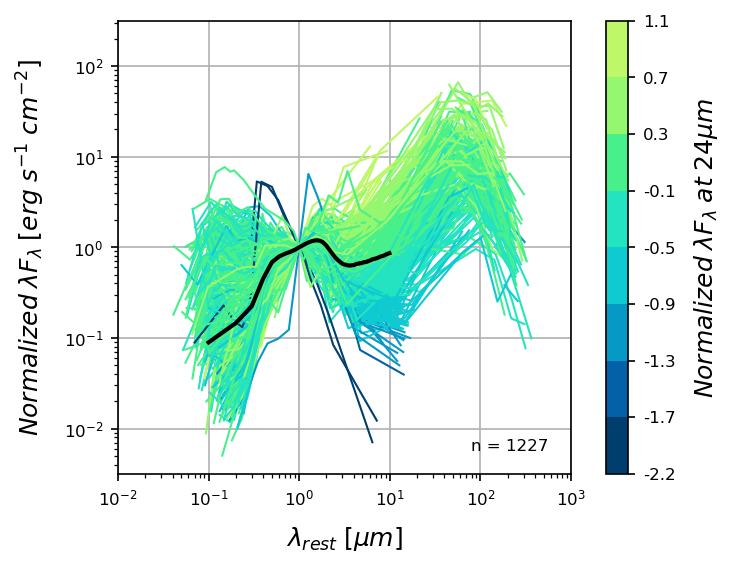

In [10]:
# plot SEDs for all color AGN 
SED.PlotSED(agnInfo['RED']['Rest Wavelength'],agnInfo['RED']['Energy Density Normalized at 1um'],cmap='r',save=adp.path_fig+'\\v2_SED_red_zAll.png')
SED.PlotSED(agnInfo['GRN']['Rest Wavelength'],agnInfo['GRN']['Energy Density Normalized at 1um'],cmap='g',save=adp.path_fig+'\\v2_SED_yel_zAll.png')
SED.PlotSED(agnInfo['BLU']['Rest Wavelength'],agnInfo['BLU']['Energy Density Normalized at 1um'],cmap='b',save=adp.path_fig+'\\v2_SED_blu_zAll.png')

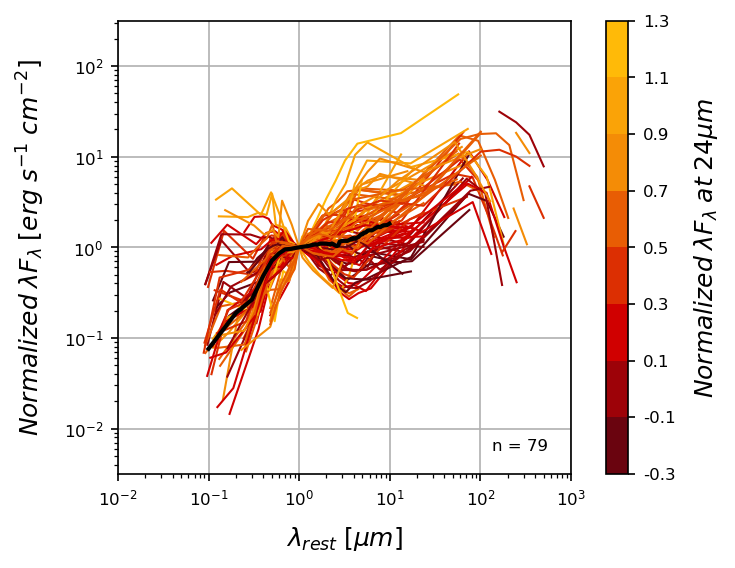

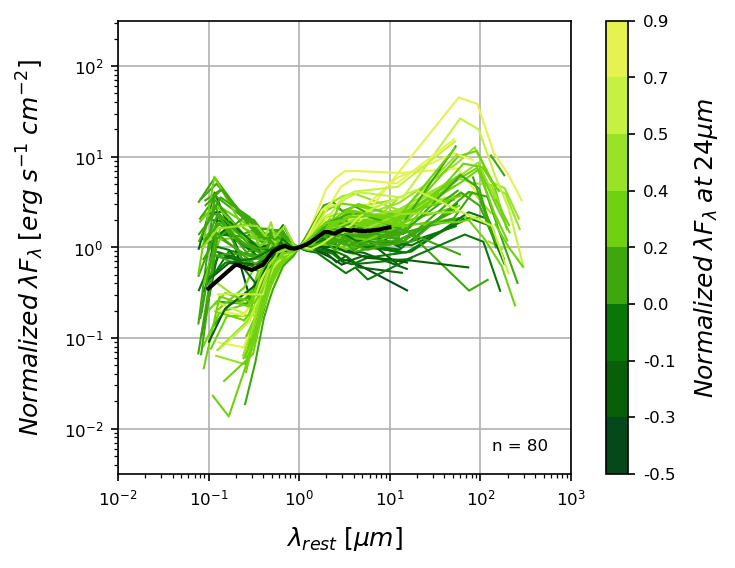

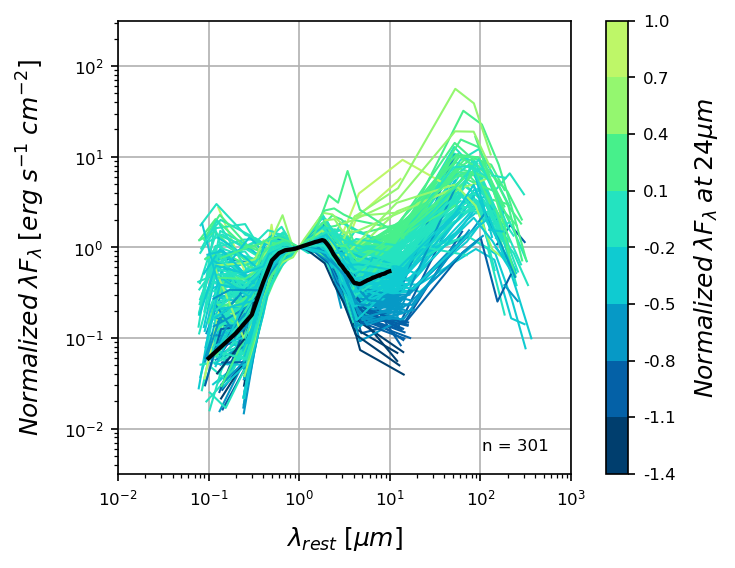

In [11]:
# plot SEDs for all color AGN 
SED.PlotSED(agnInfo_zle['RED']['Rest Wavelength'],agnInfo_zle['RED']['Energy Density Normalized at 1um'],cmap='r',save=adp.path_fig+'\\v2_SED_red_z01.png')
SED.PlotSED(agnInfo_zle['GRN']['Rest Wavelength'],agnInfo_zle['GRN']['Energy Density Normalized at 1um'],cmap='g',save=adp.path_fig+'\\v2_SED_yel_z01.png')
SED.PlotSED(agnInfo_zle['BLU']['Rest Wavelength'],agnInfo_zle['BLU']['Energy Density Normalized at 1um'],cmap='b',save=adp.path_fig+'\\v2_SED_blu_z01.png')

# Luminosity histogram

In [12]:
def MeanLineForHist(x,c='k',xtext=0.998, ytext=0.94, horizAlign='right') :
    mean = np.array(x).mean()
    min_ylim, max_ylim = plt.ylim()
    plt.axvline(mean, color=c, linestyle='dashed', linewidth=2)
    plt.text(mean*xtext, max_ylim*ytext, 'Mean: {:.1f}'.format(mean), c=c, horizontalalignment=horizAlign)

In [13]:
def LogLum(lum) : 
    l = np.array(lum) # convert to array
    l = l[l>0] # exclude zeros
    l = np.log10(l) # get log of luminosity
    return(l)

In [14]:
def PlotHist_Lum1um_Triple(
    lum1_1um,c1,
    lum2_1um,c2,
    lum3_1um,c3,
    saveStr='',
    showSum=False
):
    # set style
    adp.SetStyle()

    # get log
    lum1 = LogLum(lum1_1um)
    lum2 = LogLum(lum2_1um)
    lum3 = LogLum(lum3_1um)

    if(showSum):
        lum0 = np.concatenate((lum1,lum2,lum3))
        plt.hist(lum0,bins=np.arange(38,48,0.5), histtype='bar',  color='lightgray', linewidth=2)

    # plot histogram
    plt.hist(lum3,bins=np.arange(38,48,0.5), histtype='step', edgecolor=c3,      linewidth=2)
    plt.hist(lum2,bins=np.arange(38,48,0.5), histtype='step', edgecolor=c2,      linewidth=2)
    plt.hist(lum1,bins=np.arange(38,48,0.5), histtype='step', edgecolor=c1,      linewidth=2)

    # set height to +20% max value
    min_ylim, max_ylim = plt.ylim()
    plt.ylim(ymin=0, ymax=max_ylim+0.20*max_ylim)

    # axis ticks
    plt.xticks([38,39,40,41,42,43,44,45,46,47,48])
    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    # mean line
    MeanLineForHist(lum1,c=c1,ytext=0.94)
    MeanLineForHist(lum2,c=c2,ytext=0.89)
    MeanLineForHist(lum3,c=c3,ytext=0.84)

    # set axis lables
    plt.xlabel('$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$')
    plt.ylabel('Number')
    
    # save
    if(saveStr) :
        adp.Save(saveStr)

    # finish
    plt.show()

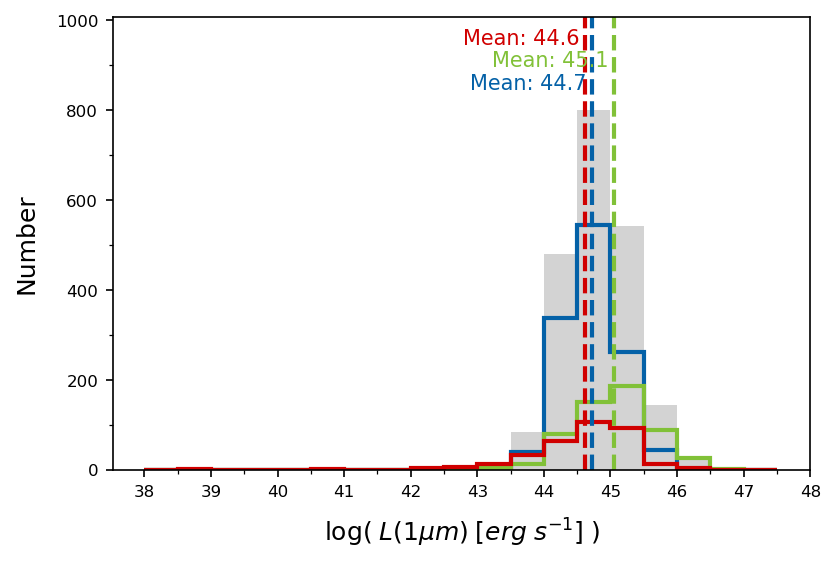

In [15]:
PlotHist_Lum1um_Triple(
    agnInfo['RED']['Luminosity at 1um'],adp.c_ir,
    agnInfo['GRN']['Luminosity at 1um'],adp.c_ir_xray,
    agnInfo['BLU']['Luminosity at 1um'],adp.c_xray,
    saveStr=adp.path_fig+'\\v2_L1umHist_zAll.png',
    showSum=True
)

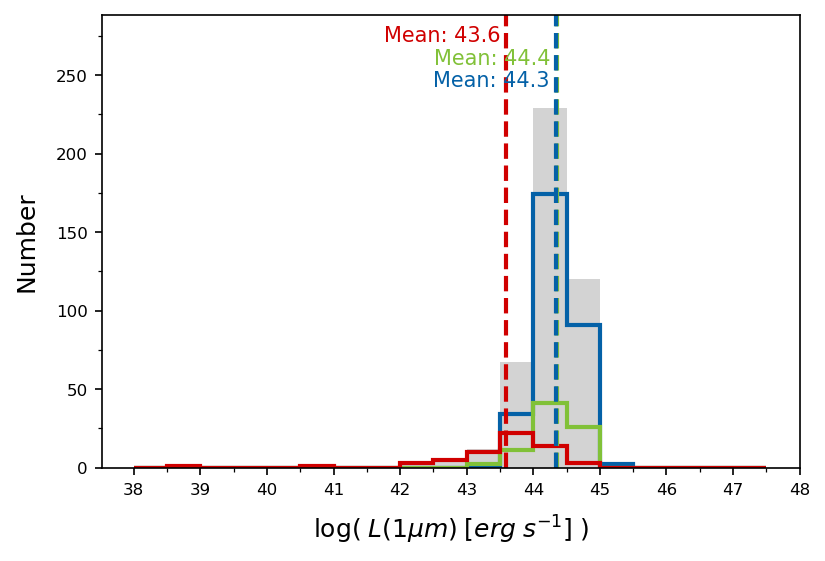

In [16]:
PlotHist_Lum1um_Triple(
    agnInfo_zle['RED']['Luminosity at 1um'],adp.c_ir,
    agnInfo_zle['GRN']['Luminosity at 1um'],adp.c_ir_xray,
    agnInfo_zle['BLU']['Luminosity at 1um'],adp.c_xray,
    saveStr=adp.path_fig+'\\v2_L1umHist_z01.png',
    showSum=True
)